In [178]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils
import torchvision


from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.auto import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [179]:
torch.cuda.device_count()

4

In [180]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
])

train = torchvision.datasets.MNIST(root = "./", train = True, download = True, transform = transforms)
test = torchvision.datasets.MNIST(root = "./", train = False, download = True, transform = transforms)

In [181]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
           )

In [182]:
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=None)
           )

In [183]:
f_cnt, n_cnt = 0, 0
train_four, train_nine = [], []

def transform_degree_n6(img):
    return torchvision.transforms.functional.rotate(img = img, angle = -6)

def transform_degree_n3(img):
    return torchvision.transforms.functional.rotate(img = img, angle = -3)

def transform_degree_3(img):
    return torchvision.transforms.functional.rotate(img = img, angle = 3)

def transform_pixel(img):
    for i in range(6):
       coord = np.random.randint(0, img.shape[1], size = 2)
       img[0, coord[0], coord[1]] = 0
    
    return img

def aug_func(idx, img):
    if i == 0: img = transform_degree_n6(img)
    if i == 1: img = transform_degree_n3(img)
    if i == 2: img = transform_degree_3(img)
    if i == 3: img = transform_pixel(img)
    return img

for img, label in train:
    if label == 4:

        if f_cnt < 3000: 
            train_four.append(img)
            for i in range(0, 4): train_four.append(aug_func(i, img))
        f_cnt+=1
    
    elif label == 9: 
        if n_cnt < 3000: 
            train_nine.append(img)
            for i in range(0, 4): train_nine.append(aug_func(i, img))   
        n_cnt+=1

In [184]:
test_four, test_nine = [], []
f_cnt, n_cnt = 0, 0

for img, label in test:
    if label == 4 and f_cnt < 400: # test nine has not enough images
        test_four.append(img)
        f_cnt += 1
    
    elif label == 9 and n_cnt < 400:
        test_nine.append(img)
        n_cnt += 1

In [185]:
train_four.__len__(), train_nine.__len__(), test_four.__len__(), test_nine.__len__()

(15000, 15000, 400, 400)

torch.Size([1, 32, 32])


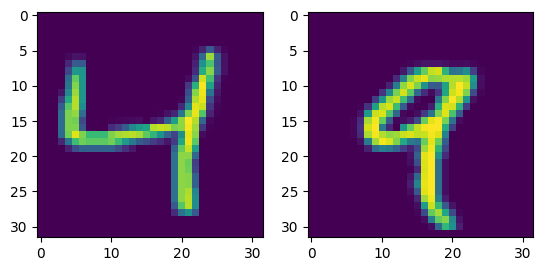

In [186]:
for f, n in zip(train_four, train_nine):
    plt.subplot(1, 2, 1); plt.imshow(f.permute(1,2,0))
    plt.subplot(1, 2, 2); plt.imshow(n.permute(1,2,0))    
    print(f.shape)
    break

In [187]:
train_f = [(img, 0) for img in train_four]
train_n = [(img, 1) for img in train_nine]

test_f = [(img, 0) for img in test_four]
test_n = [(img, 1) for img in test_nine]

train = train_f + train_n
test = test_f + test_n

random.shuffle(train)
random.shuffle(test)

traindata = [(img1[0], img2[0], 0) if img1[1] == img2[1] else (img1[0], img2[0], 1) for img1, img2 in zip(train[0::2], train[1::2])]

In [188]:
trainloader = DataLoader(traindata[3000:], batch_size=128, shuffle=True)
validloader = DataLoader(traindata[:3000], batch_size=128, shuffle=True)
trainloader.__len__(), validloader.__len__()

(94, 24)

In [189]:
class DrLIM(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels = 1, out_channels = 15, kernel_size = 6, padding = 0, stride = 1)
        self.relu = nn.ReLU()
        self.subsampling = nn.MaxPool2d(kernel_size = 3, stride = 3)
        self.layer2 = nn.Conv2d(in_channels = 15, out_channels = 30, kernel_size = 9, padding = 0, stride = 1)
        # self.relu = nn.ReLU(),
        self.fc = nn.Linear(15, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.subsampling(x)
        x = self.layer2(x)
        x = x.reshape(-1, 2, 15)
        x = self.relu(x)
        x = self.fc(x)
        return x
    

In [190]:
def CL_Loss(x1, x2, Y, m = 1):
    Euclidean_norm = torch.sqrt((x1 - x2)**2) # Euclidean Distance
    return torch.mean((1-Y).reshape(-1, 1, 1) * 1/2 * Euclidean_norm**2 + Y.reshape(-1, 1, 1) * 1/2 * torch.maximum(torch.Tensor([0]).to(device), m - Euclidean_norm)**2)

100%|██████████| 800/800 [00:00<00:00, 1402.74it/s]


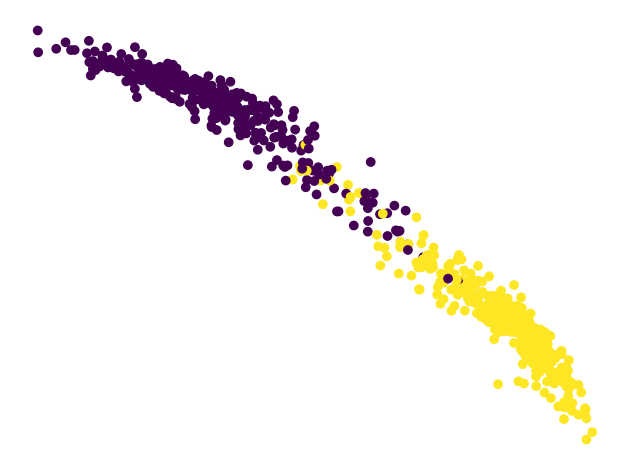

In [191]:
# valid , 
model = DrLIM().to(device)
model = nn.DataParallel(model).to(device)
model.module.load_state_dict(torch.load("./DrLIM.pt"))
model.eval()  

X, Y = None, []

with torch.no_grad():  
    for img, labels in tqdm(test):
        labels = torch.tensor(labels, dtype = torch.float64).to(device)
        img = img.to(device)
        
        output = model(img)

        if X is None:
            X = output
            Y.append(labels.item())
        else:
            X = torch.cat([X, output], dim=0)
            Y.append(labels.item())

X = X.detach().cpu().numpy()
y = np.array(Y)


plt.figure()
plt.axis('off')
plt.tight_layout()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.savefig('result.png') 